## Apply the time seres analysis per each x, y location (pixel) within a single Equi7grid tile

In [1]:
import numpy as np
import os, osr, glob
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import pandas as pd
import xarray as xr
# import TUW packages
from yeoda.products.preprocessed import SIG0DataCube
from geopathfinder.naming_conventions.yeoda_naming import YeodaFilename
#
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# import my aux functions
from auxilary_ts_tools_mm import plot_TS_fromPandaSeres, features_from_S1_TS, features_as_xrrray_ufunc

Specify the folders with a S1 datacube (a 300x300 m<sup>2</sup> Equi7Tile)

In [2]:
tile_dir1_path = r'/project/return/Share/EODC_SA020M/V01R01/E078N066T3'
tile_dir2_path = r'/project/return/Share/EODC_SA020M/V1M0R1/E078N066T3'
# specify other parameters:
dimensions=['time', 'band', 'extra_field', 'sensor_field']
#
filepaths1 = glob.glob(os.path.join(tile_dir1_path,'*.tif'))
filepaths2 = glob.glob(os.path.join(tile_dir2_path,'*.tif'))

Read the datacube:

In [3]:
sig0_dc1 = SIG0DataCube(filepaths=filepaths1, dimensions=dimensions, filename_class=YeodaFilename, sres=20, continent='SA')
sig0_dc2 = SIG0DataCube(filepaths=filepaths2, dimensions=dimensions, filename_class=YeodaFilename, sres=20, continent='SA')
# get info:
sig0_dc2.inventory[dimensions].head(5)

,time,band,extra_field,sensor_field,var_name,tile_name
0,2016-11-26 09:22:09,VH,D039,S1AIWGRDH,SIG0,E078N066T3
1,2018-01-20 09:22:44,VH,D039,S1AIWGRDH,SIG0,E078N066T3
2,2017-05-20 09:14:52,VH,D141,S1AIWGRDH,SIG0,E078N066T3
3,2017-04-14 09:13:55,VH,D141,S1AIWGRDH,SIG0,E078N066T3
4,2017-11-21 09:22:21,VH,D039,S1AIWGRDH,SIG0,E078N066T3


Filter by date:

In [4]:
toi_start, toi_end = datetime(2017, 1, 1), datetime(2021, 1, 1)
sig0_dc1 = sig0_dc1.filter_by_dimension([(toi_start, toi_end)], [(">=", "<")], name="time", inplace=True)
sig0_dc2 = sig0_dc2.filter_by_dimension([(toi_start, toi_end)], [(">=", "<")], name="time", inplace=True)

Select bands:

In [5]:
sig0_vv_dc1 = sig0_dc1.filter_by_dimension('VV', name='band')
sig0_vh_dc1 = sig0_dc1.filter_by_dimension('VH', name='band')
#
sig0_vv_dc2 = sig0_dc2.filter_by_dimension('VV', name='band')
sig0_vh_dc2 = sig0_dc2.filter_by_dimension('VH', name='band')

Merge and sort the datacubes:

In [6]:
sig0_vv_dc = sig0_vv_dc1.unite(sig0_vv_dc2)
sig0_vv_dc = sig0_vv_dc.sort_by_dimension('time', ascending=True)
#
sig0_vh_dc = sig0_vh_dc1.unite(sig0_vh_dc2)
sig0_vh_dc = sig0_vh_dc.sort_by_dimension('time', ascending=True)
#
sig0_vv_dc.inventory

,filepath,time,band,extra_field,sensor_field,var_name,tile_name
732,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:07,VV,D039,S1AIWGRDH,SIG0,E078N066T3
452,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:32,VV,D039,S1AIWGRDH,SIG0,E078N066T3
537,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:57,VV,D039,S1AIWGRDH,SIG0,E078N066T3
630,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-08 09:13:54,VV,D141,S1AIWGRDH,SIG0,E078N066T3
782,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-08 09:14:19,VV,D141,S1AIWGRDH,SIG0,E078N066T3
...,...,...,...,...,...,...,...
31,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-23 09:23:29,VV,D039,S1A,SIG0,E078N066T3
87,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-29 09:22:39,VV,D039,S1B,SIG0,E078N066T3
319,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-30 09:14:26,VV,D141,S1A,SIG0,E078N066T3
222,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-30 09:14:51,VV,D141,S1A,SIG0,E078N066T3


Load data 

In [156]:
sig0_vv_dc_chunk1 = sig0_vv_dc.load_by_pixels(1000, 1000, row_size=200, col_size=200, dtype='xarray')
sig0_vh_dc_chunk1 = sig0_vv_dc.load_by_pixels(1000, 1000, row_size=200, col_size=200, dtype='xarray')

Get info

In [157]:
print(sig0_vv_dc_chunk1)

<xarray.Dataset>
Dimensions:  (time: 818, y: 200, x: 200)
Coordinates:
  * time     (time) datetime64[ns] 2017-01-01T09:22:07 ... 2020-12-30T09:15:16
  * y        (y) float64 6.88e+06 6.88e+06 6.88e+06 ... 6.876e+06 6.876e+06
  * x        (x) float64 7.82e+06 7.82e+06 7.82e+06 ... 7.824e+06 7.824e+06
Data variables:
    1        (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan nan


Get the in-memory size 

In [158]:
print('Datacube size in memory is:', np.round(sig0_vv_dc_chunk1.nbytes/(1024*1024), 1), 'MB')

Datacube size in memory is: 249.6 MB


Rename the variavle

In [159]:
sig0_vv_dc_chunk1 = sig0_vv_dc_chunk1.rename({'1':'sig0_vv'})

In [160]:
sig0_vh_dc_chunk1 = sig0_vh_dc_chunk1.rename({'1':'sig0_vh'})

Plot a time seres and inspect values:

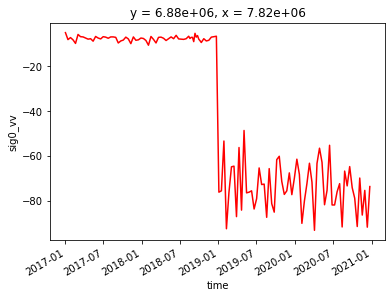

In [161]:
sig0_vv_dc_chunk1.sig0_vv.isel(x=0, y=0).dropna(dim='time').plot(linestyle='-', color='r')

Rescale the data in 2019 and 2020

In [162]:
sig0_vv_dc_chunk1['sig0_vv'].loc[slice('2019-1-1','2021-1-1'), :, :] = sig0_vv_dc_chunk1.sel(time=slice('2019-1-1','2021-1-1')).apply(lambda x: np.round(x/10.,1)).sig0_vv.values
sig0_vh_dc_chunk1['sig0_vh'].loc[slice('2019-1-1','2021-1-1'), :, :] = sig0_vh_dc_chunk1.sel(time=slice('2019-1-1','2021-1-1')).apply(lambda x: np.round(x/10.,1)).sig0_vh.values

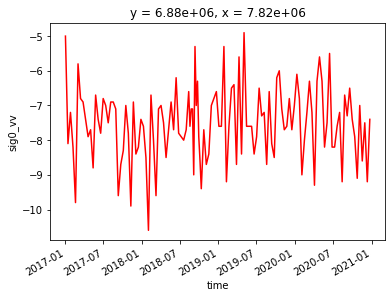

In [163]:
sig0_vv_dc_chunk1.sig0_vv.isel(x=0, y=0).dropna(dim='time').plot(linestyle='-', color='r')

Convert to pandas seres and plot

In [207]:
sig0_vv_ts = sig0_vv_dc_chunk1.sig0_vv.isel(x=120, y=135).dropna(dim='time').to_series()

<AxesSubplot:xlabel='Time', ylabel='Bacscatter Intensity [dB]'>

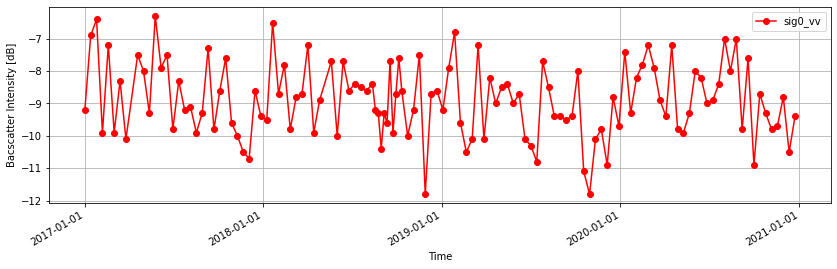

In [211]:
my_xticks = pd.date_range(datetime(2017,1,1), datetime(2021,1,1), freq='YS')
sig0_vv_ts.plot(style='ro-', xticks=my_xticks, grid=True, figsize=(14,4), legend=True, xlabel='Time', ylabel='Bacscatter Intensity [dB]')

Round the time and resample to 6 day TS:

In [212]:
sig0_vv_ts.index = sig0_vv_ts.index.round('D')
#
sig0_vv_ts_6d = sig0_vv_ts.resample('6D').interpolate(method='linear')

<AxesSubplot:xlabel='Time', ylabel='Bacscatter Intensity [dB]'>

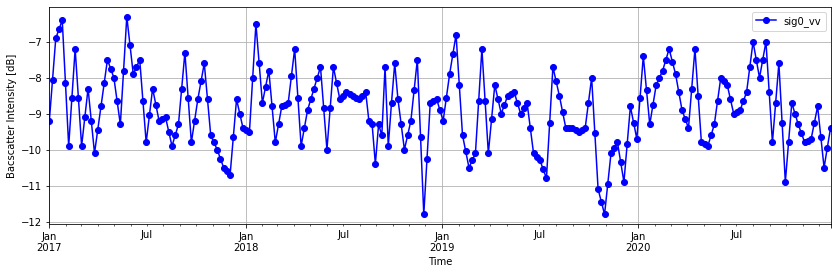

In [213]:
sig0_vv_ts_6d.plot(style='bo-',grid=True, figsize=(14,4), legend=True, xlabel='Time', ylabel='Bacscatter Intensity [dB]')

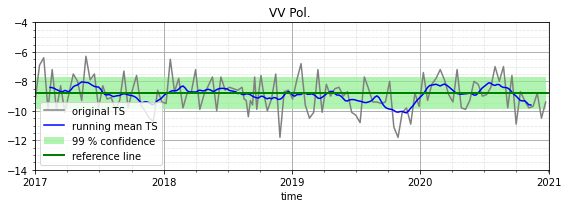

In [214]:
plot_TS_fromPandaSeres(sig0_vv_ts_6d)

In [215]:
myFeatures_v2 = features_from_S1_TS(sig0_vv_ts_6d)
myFeatures_v2

[0,
 -8.784506172839507,
 1.1104319441325075,
 1,
 0,
 0,
 0.8188271604938269,
 0,
 54.0,
 1.3554938271604957,
 numpy.datetime64('2019-11-23T00:00:00.000000000'),
 -42,
 6,
 54,
 3.015493827160494,
 numpy.datetime64('2019-10-30T00:00:00.000000000'),
 -24,
 nan]

## xarray-approach: apply the time-seres analysis per each x, y location in xarray

Prepare timestamps

In [170]:
ts_time_stamps = sig0_vv_dc_chunk1['sig0_vv'][:,0, 0].time.values

Get features per each pixel

In [171]:
#%%timeit
dist_out = xr.apply_ufunc(features_as_xrrray_ufunc, 
                          sig0_vv_dc_chunk1['sig0_vv'],
                          ts_time_stamps,
                          input_core_dims=[["time"], []],
                          output_core_dims=[["features"]]
                         )

In [ ]:
# timeit, 200x200 pixels: 4min 49s ± 4.23 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
# timeit, 100x100 pixels: 2min 18s ± 401 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# timeit, 50x50 pixel: 18.6 s ± 91.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# timeit, 10x10 pixels: 741 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

In [175]:
# convert output to dataset
dist_out_ds = dist_out.to_dataset(dim='features')

In [176]:
dist_out_ds = dist_out_ds.rename({0:'exception_label', 1:'ref_mean', 2:'error_margin',
                                  3:'num_of_segments', 4:'TS_end_flag', 5:'TS_end_flag_long', 6:'TS_end_mag',
                                  7:'seg_id', 8:'seg_size', 9:'max_mag', 10:'max_mag_date', 11:'t_pre', 12:'t_post', 13:'t_total',
                                  14:'max_mag_org', 15:'max_mag_org_date', 16:'t_mag_org',
                                  17:'seg2_size'})

In [177]:
dist_out_ds

<xarray.Dataset>
Dimensions:           (y: 200, x: 200)
Coordinates:
  * y                 (y) float64 6.88e+06 6.88e+06 ... 6.876e+06 6.876e+06
  * x                 (x) float64 7.82e+06 7.82e+06 ... 7.824e+06 7.824e+06
Data variables: (12/18)
    exception_label   (y, x) float64 3.0 2.0 0.0 2.0 3.0 ... 0.0 3.0 3.0 3.0 0.0
    ref_mean          (y, x) float64 -7.682 -7.384 -6.938 ... -7.767 -7.432
    error_margin      (y, x) float64 0.9774 0.8576 0.747 ... 0.9884 0.9387 1.172
    num_of_segments   (y, x) float64 nan nan 1.0 nan nan ... 2.0 nan nan nan 1.0
    TS_end_flag       (y, x) float64 nan nan 0.0 nan nan ... 1.0 nan nan nan 0.0
    TS_end_flag_long  (y, x) float64 2.0 2.0 0.0 2.0 2.0 ... 1.0 2.0 2.0 2.0 1.0
    ...                ...
    t_post            (y, x) float64 nan nan 11.0 nan nan ... nan nan nan 6.0
    t_total           (y, x) float64 nan nan 29.0 nan nan ... nan nan nan 18.0
    max_mag_org       (y, x) float64 nan nan 2.062 nan nan ... nan nan nan 2.968
    max_mag_org_date  (y, x) float64 nan nan 1.57e+18 nan ... nan nan 1.605e+18
    t_mag_org         (y, x) float64 nan nan 11.0 nan nan ... nan nan nan 6.0
    seg2_size         (y, x) float64 nan nan nan nan nan ... nan nan nan nan

In [178]:
print('Datacube size in memory is:', np.round(dist_out_ds.nbytes/(1024*1024), 1), 'MB')

Datacube size in memory is: 5.5 MB


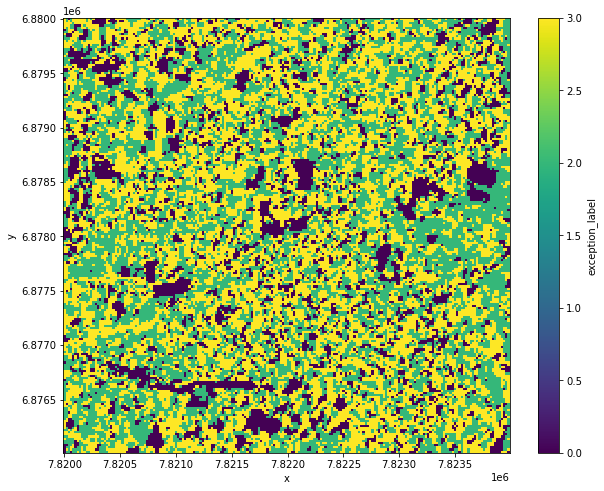

In [179]:
#d plotting:
#dist_out_ds.seg_size.astype('float').plot()
feature_da = dist_out_ds.exception_label.astype('int')
feature_da.plot(figsize=(10, 8))

get a list of row and columnns where the exception label is 0

In [201]:
aa = np.column_stack(np.where(feature_da.where(feature_da == 0).values))

In [206]:
aa[20000, :]

array([120, 135])